
---

#### Name: 陳永承
#### Student ID: 0712534

#### 2020 Introduction to Machine Learning Program Assignment #2 - Decision Tree & Random Forest & KNN
---

In [1]:
import numpy as np
import pandas as pd
from sklearn import tree
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn import preprocessing
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import pydotplus
from sklearn import neighbors


In [2]:
def getgrade(i):
    if i>=16:
        return 1  #A
    elif i>=14:
        return 2
    elif i>=12:
        return 3
    elif i>=10:
        return 4
    else:
        return 5 #F
    

def K_Folds(data):
    indexNo = len(data) / 3
    return [data[round(indexNo * i):round(indexNo * (i + 1))] for i in range(3)]

## 1.Data Input
先把csv檔下載，再讀用pd內建的read_csv讀檔，並以";"分隔

In [3]:
data=pd.read_csv('student-por.csv',sep=';')
data2=pd.read_csv('student-mat.csv',sep=';')

## 2.Data Preprocessing
先新增"PASS"跟"Erasmus"的column，該2欄數值為題目要求。<br>
因為特徵多為2類別，因此把非數值資料的部分轉換成2欄，符合的該欄為1，不符合為0<br>
以"sex"為例，分成"sex female"與"sex male"兩個欄位，然後該sample符合該特徵的為1，不符合的為0<br>
<br>
shuffle的方法為sklearn的內建函數<br>
<br>
label本身改成數值資料，pass的為1，fail的為0；Erasmus的部分由A到F為1至5。<br>

In [4]:

data=data.append(data2)
data['pass']=data.apply(lambda row:1 if row['G3']>=10 else 0,axis=1)
data['Erasmus']=data.apply(lambda row: getgrade(row['G3']),axis=1)
data=data.drop(['G3'],axis=1)
data=pd.get_dummies(data,columns=['sex','school','address','famsize','Pstatus','Mjob','Fjob',
                                  'reason','guardian','schoolsup','famsup','paid','activities',
                                  'nursery','higher','internet','romantic'])
feature=np.array(data.drop(['pass','Erasmus'],axis=1))
Five_level_label=np.array(data['Erasmus'])
Binary_label=np.array(data['pass'])

"""
Shuffle the data.
"""
feature, Binary_label,Five_level_label = shuffle(feature, Binary_label,Five_level_label, random_state=0)

## 4.Validation
Holdout validation<br>
sklearn的train_test_split可以解決這個問題<br>
<br>
K-fold cross<br>
先將資料切3等分(函數宣告在最前面)，然後這3份資料倆倆合併就是training data，沒被合併的是testing data<br>

In [5]:
"""
Holdout validation
"""
#binary
H_B_F_train,H_B_F_test,H_B_L_train,H_B_L_test=train_test_split(feature,Binary_label , test_size=0.3)
#5-level
H_Five_F_train,H_Five_F_test,H_Five_L_train,H_Five_L_test=train_test_split(feature,Five_level_label , test_size=0.3)

"""
K-fold cross
"""
#binary
K_B_F=K_Folds(feature)
K_B_L=K_Folds(Binary_label)

K_B_F_train0=t1=np.append(K_B_F[1],K_B_F[2],axis=0)
K_B_L_train0=t1=np.append(K_B_L[1],K_B_L[2],axis=0)

K_B_F_train1=t1=np.append(K_B_F[0],K_B_F[2],axis=0)
K_B_L_train1=t1=np.append(K_B_L[0],K_B_L[2],axis=0)

K_B_F_train2=t1=np.append(K_B_F[1],K_B_F[0],axis=0)
K_B_L_train2=t1=np.append(K_B_L[1],K_B_L[0],axis=0)
#5-level
K_Five_F=K_Folds(feature)
K_Five_L=K_Folds(Five_level_label)

K_F_F_train0=t1=np.append(K_Five_F[1],K_Five_F[2],axis=0)
K_F_L_train0=t1=np.append(K_Five_L[1],K_Five_L[2],axis=0)

K_F_F_train1=t1=np.append(K_Five_F[0],K_Five_F[2],axis=0)
K_F_L_train1=t1=np.append(K_Five_L[0],K_Five_L[2],axis=0)

K_F_F_train2=t1=np.append(K_Five_F[1],K_Five_F[0],axis=0)
K_F_L_train2=t1=np.append(K_Five_L[1],K_Five_L[0],axis=0)

## 3.Model Construction -Decision Tree model
sklearn中的DecisionTreeClassifier可以直接建model<br>
我使用的Decision tree的演算法為gini(將參數criterion='gini')，gini的演算法的特點為連續型的資料與離散型(需轉換成數值)的資料皆能使用。<br>
切分的方式為依照gini係數，選一個feature與其value切分完gini係數最小的。<br>
gini的的值在giniCompute這個函數中定義，其係數為1-sum((P(label符合這個set))^2)，所以數字越小純度越高。<br>
而信息增益量為  原本的gini扣掉(這次分類的gini*其佔比)<br>
接著每次都選一個sample中的一個feature，以該數值試著分類，把gini數值最低的紀錄。最後以該數值作為新的node分類<br>
比這數值小於等於的走左邊，比這數值大的走右邊。<br>

In [7]:
"""
Decision Tree
"""
H_decision_Bitree=tree.DecisionTreeClassifier(criterion='gini').fit(H_B_F_train,H_B_L_train)
H_B_tree_perdict=H_decision_Bitree.predict(H_B_F_test)
K0_decision_Bitree=tree.DecisionTreeClassifier(criterion='gini').fit(K_B_F_train0,K_B_L_train0)
K0_B_Bitree_perdict=K0_decision_Bitree.predict(K_B_F[0])
K1_decision_Bitree=tree.DecisionTreeClassifier(criterion='gini').fit(K_B_F_train1,K_B_L_train1)
K1_B_Bitree_perdict=K1_decision_Bitree.predict(K_B_F[1])
K2_decision_Bitree=tree.DecisionTreeClassifier(criterion='gini').fit(K_B_F_train2,K_B_L_train2)
K2_B_Bitree_perdict=K2_decision_Bitree.predict(K_B_F[2])
H_tree=tree.DecisionTreeClassifier(criterion='gini').fit(H_Five_F_train,H_Five_L_train)
H_F_tree_perdict=H_tree.predict(H_Five_F_test)
K0_tree=tree.DecisionTreeClassifier(criterion='gini').fit(K_F_F_train0,K_F_L_train0)
K0_F_tree_perdict=H_tree.predict(K_Five_F[0])
K1_tree=tree.DecisionTreeClassifier(criterion='gini').fit(K_F_F_train1,K_F_L_train1)
K1_F_tree_perdict=H_tree.predict(K_Five_F[1])
K2_tree=tree.DecisionTreeClassifier(criterion='gini').fit(K_F_F_train2,K_F_L_train2)
K2_F_tree_perdict=H_tree.predict(K_Five_F[2])

## 3.Model Construction -Random Forest
Random Forest使用sklearn中的RandomForestClassifier，然後其n_estimators參數為要種幾棵樹(這裡設為50)<br>
接者將training data放入他會自動隨機選取sample造出50棵樹並給他們自己投票<br>
其造樹的演算法預設為gini。<br>
<br>
K-fold cross-validation v.s. Random Forest
1. K-fold cross-validation : K的數值為要做幾次這maching learn的訓練，因此在random forest中，就是要做K次random forest。因為K=3，所以有3組training data跟 testing data。<br>第一次做random forest時，把第一組的training data放入訓練出50棵樹在投票，再把第一組的testing data放入第一次訓練完的樹預測並看他的精準度。<br>而第二組與第三組也是如此，也就是每組訓練50棵樹，那3組共訓練150棵樹。<br>但是每組的樹與每組資料之間並不會交替使用，像是第一組的樹只適用於第一組的testing data<br>因為第二組的testing data有參與第一次的訓練，所以如果用在第二組的testing data，該樹會其準無比，且這棵樹偷看答案，因此不能把第一次的樹放到第二組的testing data預測。最後將各組的精準度等資訊平均<br>
<br>
2. Random Forest : 原本的training data中隨機以feature或sample造樹，在讓training data投票，選出最好的樹。

In [8]:
"""
Random Forest
"""
H_B_rfc=RandomForestClassifier(n_estimators=50)
H_B_rfc.fit(H_B_F_train,H_B_L_train)
H_B_rfc_predict=H_B_rfc.predict(H_B_F_test)

K0_B_rfc=RandomForestClassifier(n_estimators=50)
K0_B_rfc.fit(K_B_F_train0,K_B_L_train0)
K0_B_rfc_predict=K0_B_rfc.predict(K_B_F[0])
K1_B_rfc=RandomForestClassifier(n_estimators=50)
K1_B_rfc.fit(K_B_F_train1,K_B_L_train1)
K1_B_rfc_predict=K1_B_rfc.predict(K_B_F[1])
K2_B_rfc=RandomForestClassifier(n_estimators=50)
K2_B_rfc.fit(K_B_F_train2,K_B_L_train2)
K2_B_rfc_predict=K2_B_rfc.predict(K_B_F[2])

H_F_rfc=RandomForestClassifier(n_estimators=50)
H_F_rfc.fit(H_Five_F_train,H_Five_L_train)
H_F_rfc_predict=H_F_rfc.predict(H_Five_F_test)

K0_F_rfc=RandomForestClassifier(n_estimators=50)
K0_F_rfc.fit(K_F_F_train0,K_F_L_train0)
K0_F_rfc_predict=K0_F_rfc.predict(K_Five_F[0])
K1_F_rfc=RandomForestClassifier(n_estimators=50)
K1_F_rfc.fit(K_F_F_train1,K_F_L_train1)
K1_F_rfc_predict=K1_F_rfc.predict(K_Five_F[1])
K2_F_rfc=RandomForestClassifier(n_estimators=50)
K2_F_rfc.fit(K_F_F_train2,K_F_L_train2)
K2_F_rfc_predict=K2_F_rfc.predict(K_Five_F[2])

## 3.Model Construction -K-Nearest Neighbor
先前的data processing時已經把所有資料改成數值資料了<br>
normalize的方法為sklearn內建的preprocessing.scale，這函數跑完就會把每個feature標準化<br>
model的建造方法為sklearn中的KNeighborsClassifier，n_neighbors可以調K的數字，p的數值為其對應的距離算法(p: 1→曼哈頓距離 / 2→歐基里德距離 )
<br>
再把training data給.fit一下就訓練完了
<br>
本次3個K值分別為3,10,20

In [9]:
"""
normalize data
"""

H_B_nor_F_train = preprocessing.scale(H_B_F_train)
H_B_nor_F_test = preprocessing.scale(H_B_F_test)

K_B_nor_F_train0=preprocessing.scale(K_B_F_train0)
K_nor_B_F0=preprocessing.scale(K_B_F[0])
K_B_nor_F_train1=preprocessing.scale(K_B_F_train1)
K_nor_B_F1=preprocessing.scale(K_B_F[1])
K_B_nor_F_train2=preprocessing.scale(K_B_F_train2)
K_nor_B_F2=preprocessing.scale(K_B_F[2])


H_F_nor_F_train = preprocessing.scale(H_Five_F_train)
H_F_nor_F_test = preprocessing.scale(H_Five_F_test)

K_F_nor_F_train0=preprocessing.scale(K_F_F_train0)
K_nor_F_F0=preprocessing.scale(K_Five_F[0])
K_F_nor_F_train1=preprocessing.scale(K_F_F_train1)
K_nor_F_F1=preprocessing.scale(K_Five_F[1])
K_F_nor_F_train2=preprocessing.scale(K_F_F_train2)
K_nor_F_F2=preprocessing.scale(K_Five_F[2])

"""
KNN
"""
# Holdout
H_B_K1KNN=KNeighborsClassifier(n_neighbors=3,p=2,weights='distance',algorithm='brute')
H_B_K1KNN.fit(H_B_nor_F_train,H_B_L_train)
H_B_K1KNN_predict=H_B_K1KNN.predict(H_B_nor_F_test)
H_B_K2KNN=KNeighborsClassifier(n_neighbors=10,p=2,weights='distance',algorithm='brute')
H_B_K2KNN.fit(H_B_nor_F_train,H_B_L_train)
H_B_K2KNN_predict=H_B_K2KNN.predict(H_B_nor_F_test)
H_B_K3KNN=KNeighborsClassifier(n_neighbors=20,p=2,weights='distance',algorithm='brute')
H_B_K3KNN.fit(H_B_nor_F_train,H_B_L_train)
H_B_K3KNN_predict=H_B_K3KNN.predict(H_B_nor_F_test)

# K-fold
K_B_K1KNN=KNeighborsClassifier(n_neighbors=3,p=2,weights='distance',algorithm='brute')
K_B_K2KNN=KNeighborsClassifier(n_neighbors=10,p=2,weights='distance',algorithm='brute')
K_B_K3KNN=KNeighborsClassifier(n_neighbors=20,p=2,weights='distance',algorithm='brute')

K_B_K1KNN.fit(K_B_nor_F_train0,K_B_L_train0)
K0_B_K1KNN_predict=K_B_K1KNN.predict(K_nor_B_F0)
K_B_K1KNN.fit(K_B_nor_F_train1,K_B_L_train1)
K1_B_K1KNN_predict=K_B_K1KNN.predict(K_nor_B_F1)
K_B_K1KNN.fit(K_B_nor_F_train2,K_B_L_train2)
K2_B_K1KNN_predict=K_B_K1KNN.predict(K_nor_B_F2)

K_B_K2KNN.fit(K_B_nor_F_train0,K_B_L_train0)
K0_B_K2KNN_predict=K_B_K2KNN.predict(K_nor_B_F0)
K_B_K2KNN.fit(K_B_nor_F_train1,K_B_L_train1)
K1_B_K2KNN_predict=K_B_K2KNN.predict(K_nor_B_F1)
K_B_K2KNN.fit(K_B_nor_F_train2,K_B_L_train2)
K2_B_K2KNN_predict=K_B_K2KNN.predict(K_nor_B_F2)

K_B_K3KNN.fit(K_B_nor_F_train0,K_B_L_train0)
K0_B_K3KNN_predict=K_B_K3KNN.predict(K_nor_B_F0)
K_B_K3KNN.fit(K_B_nor_F_train1,K_B_L_train1)
K1_B_K3KNN_predict=K_B_K3KNN.predict(K_nor_B_F1)
K_B_K3KNN.fit(K_B_nor_F_train2,K_B_L_train2)
K2_B_K3KNN_predict=K_B_K3KNN.predict(K_nor_B_F2)

# Holdout
H_F_K1KNN=KNeighborsClassifier(n_neighbors=3,p=2,weights='distance',algorithm='brute')
H_F_K1KNN.fit(H_F_nor_F_train,H_Five_L_train)
H_F_K1KNN_predict=H_F_K1KNN.predict(H_F_nor_F_test)
H_F_K2KNN=KNeighborsClassifier(n_neighbors=10,p=2,weights='distance',algorithm='brute')
H_F_K2KNN.fit(H_F_nor_F_train,H_Five_L_train)
H_F_K2KNN_predict=H_F_K2KNN.predict(H_F_nor_F_test)
H_F_K3KNN=KNeighborsClassifier(n_neighbors=20,p=2,weights='distance',algorithm='brute')
H_F_K3KNN.fit(H_F_nor_F_train,H_Five_L_train)
H_F_K3KNN_predict=H_F_K3KNN.predict(H_F_nor_F_test)

# K-fold
K_F_K1KNN=KNeighborsClassifier(n_neighbors=3,p=2,weights='distance',algorithm='brute')
K_F_K2KNN=KNeighborsClassifier(n_neighbors=10,p=2,weights='distance',algorithm='brute')
K_F_K3KNN=KNeighborsClassifier(n_neighbors=20,p=2,weights='distance',algorithm='brute')

K_F_K1KNN.fit(K_F_nor_F_train0,K_F_L_train0)
K0_F_K1KNN_predict=K_F_K1KNN.predict(K_nor_F_F0)
K_F_K1KNN.fit(K_F_nor_F_train1,K_F_L_train1)
K1_F_K1KNN_predict=K_F_K1KNN.predict(K_nor_F_F1)
K_F_K1KNN.fit(K_F_nor_F_train2,K_F_L_train2)
K2_F_K1KNN_predict=K_F_K1KNN.predict(K_nor_F_F2)

K_F_K2KNN.fit(K_F_nor_F_train0,K_F_L_train0)
K0_F_K2KNN_predict=K_F_K2KNN.predict(K_nor_F_F0)
K_F_K2KNN.fit(K_F_nor_F_train1,K_F_L_train1)
K1_F_K2KNN_predict=K_F_K2KNN.predict(K_nor_F_F1)
K_F_K2KNN.fit(K_F_nor_F_train2,K_F_L_train2)
K2_F_K2KNN_predict=K_F_K2KNN.predict(K_nor_F_F2)

K_F_K3KNN.fit(K_F_nor_F_train0,K_F_L_train0)
K0_F_K3KNN_predict=K_F_K3KNN.predict(K_nor_F_F0)
K_F_K3KNN.fit(K_F_nor_F_train1,K_F_L_train1)
K1_F_K3KNN_predict=K_F_K3KNN.predict(K_nor_F_F1)
K_F_K3KNN.fit(K_F_nor_F_train2,K_F_L_train2)
K2_F_K3KNN_predict=K_F_K3KNN.predict(K_nor_F_F2)


## 5.Results -Confusion matrix
Confusion matrix用scikit-learn內建的confusion_matrix產生<br>
用法為confusion_matrix(test_label,predict)<br>
再使用mlxtend.plotting中的plot_confusion_matrix產生圖表<br>

<function matplotlib.pyplot.show(*args, **kw)>

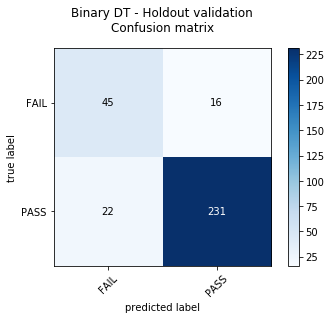

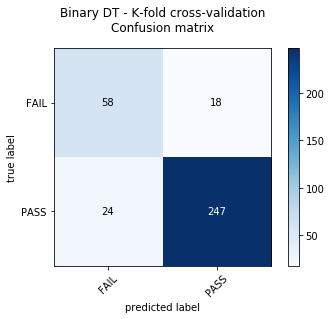

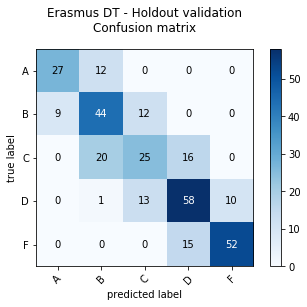

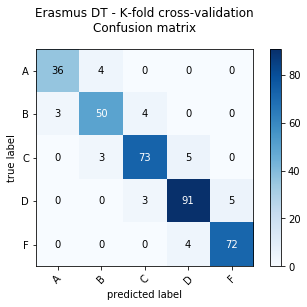

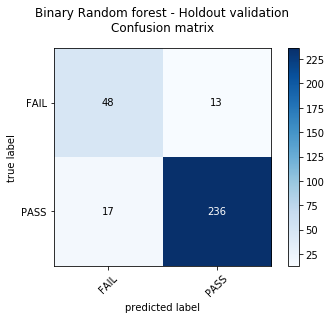

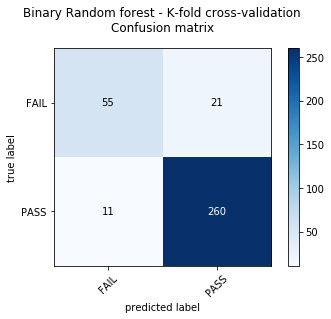

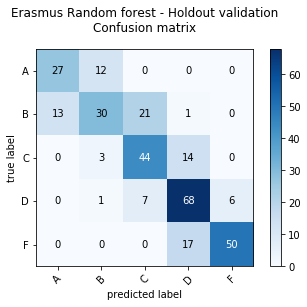

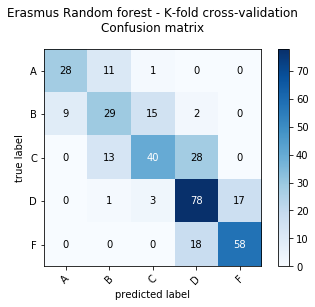

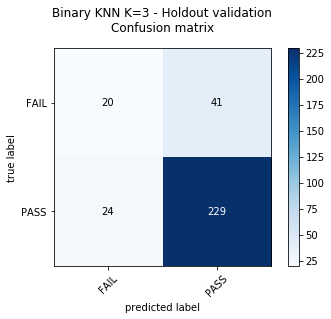

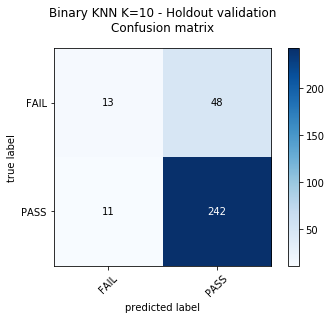

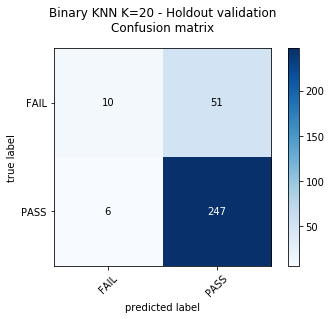

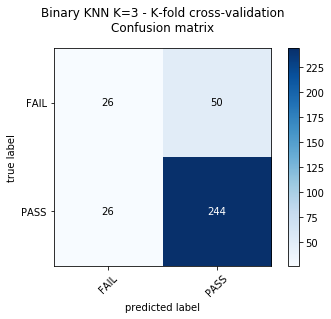

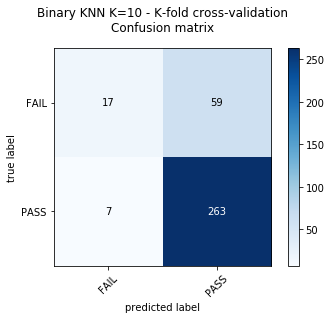

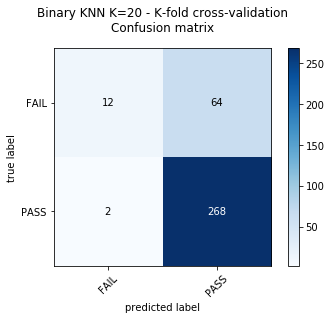

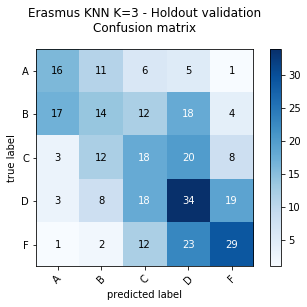

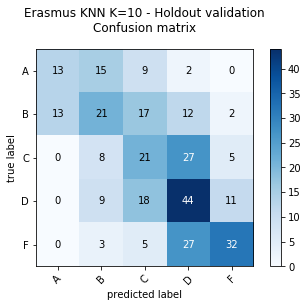

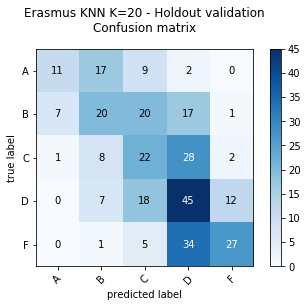

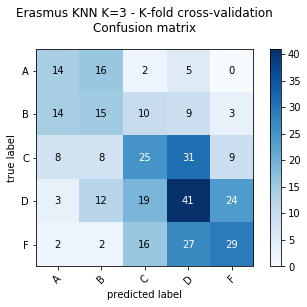

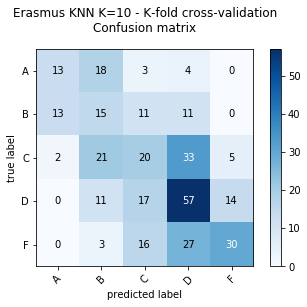

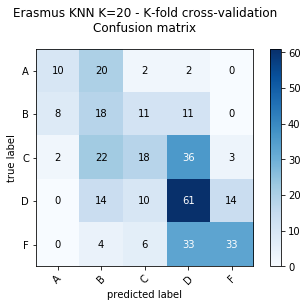

In [10]:
column_name=['FAIL','PASS']
Five_column_name=['A','B','C','D','F']

"""
binary decision - Holdout validation
"""
binary_tree=confusion_matrix(H_B_L_test,H_B_tree_perdict)
figuer,ax=plot_confusion_matrix(conf_mat=binary_tree,show_absolute=True,show_normed=False,colorbar=True,class_names=column_name)
plt.title('Binary DT - Holdout validation\nConfusion matrix')
plt.show
"""
binary decision - K-fold cross-validation
"""
K_B_CM=confusion_matrix(K_B_L[0], K0_B_Bitree_perdict)
K0_B_CM=confusion_matrix(K_B_L[0], K0_B_Bitree_perdict)
K1_B_CM=confusion_matrix(K_B_L[1], K1_B_Bitree_perdict)
K2_B_CM=confusion_matrix(K_B_L[2], K2_B_Bitree_perdict)
for i in range(2):
    for j in range(2):
        K_B_CM[i][j]=(K0_B_CM[i][j]+K1_B_CM[i][j]+K2_B_CM[i][j])/3
figuer,ax=plot_confusion_matrix(conf_mat=K_B_CM,show_absolute=True,show_normed=False,colorbar=True,class_names=column_name)
plt.title('Binary DT - K-fold cross-validation\nConfusion matrix')
plt.show


"""
Erasmus decision - Holdout validation
"""
F_tree=confusion_matrix(H_Five_L_test,H_F_tree_perdict)
figuer,ax=plot_confusion_matrix(conf_mat=F_tree,show_absolute=True,show_normed=False,colorbar=True,class_names=Five_column_name)
plt.title('Erasmus DT - Holdout validation\nConfusion matrix')
plt.show

"""
Erasmus decision - K-fold cross-validation
"""
K_F_CM=confusion_matrix(K_Five_L[0], K0_F_tree_perdict)
K0_F_CM=confusion_matrix(K_Five_L[0], K0_F_tree_perdict)
K1_F_CM=confusion_matrix(K_Five_L[1], K1_F_tree_perdict)
K2_F_CM=confusion_matrix(K_Five_L[2], K2_F_tree_perdict)
for i in range(2):
    for j in range(2):
        K_F_CM[i][j]=(K0_F_CM[i][j]+K1_F_CM[i][j]+K2_F_CM[i][j])/3
figuer,ax=plot_confusion_matrix(conf_mat=K_F_CM,show_absolute=True,show_normed=False,colorbar=True,class_names=Five_column_name)
plt.title('Erasmus DT - K-fold cross-validation\nConfusion matrix')
plt.show


"""
binary Random forest - Holdout validation
"""
H_rfc_CM=confusion_matrix(H_B_L_test,H_B_rfc_predict)
figuer,ax=plot_confusion_matrix(conf_mat=H_rfc_CM,show_absolute=True,show_normed=False,colorbar=True,class_names=column_name)
plt.title('Binary Random forest - Holdout validation\nConfusion matrix')
plt.show

"""
binary Random forest - K-fold cross-validation
"""
K_B_rfc_CM=confusion_matrix(K_B_L[0], K0_B_rfc_predict)
K0_B_rfc_CM=confusion_matrix(K_B_L[0], K0_B_rfc_predict)
K1_B_rfc_CM=confusion_matrix(K_B_L[1], K1_B_rfc_predict)
K2_B_rfc_CM=confusion_matrix(K_B_L[2], K2_B_rfc_predict)
for i in range(2):
    for j in range(2):
        K_B_rfc_CM[i][j]=(K0_B_rfc_CM[i][j]+K1_B_rfc_CM[i][j]+K2_B_rfc_CM[i][j])/3
figuer,ax=plot_confusion_matrix(conf_mat=K_B_rfc_CM,show_absolute=True,show_normed=False,colorbar=True,class_names=column_name)
plt.title('Binary Random forest - K-fold cross-validation\nConfusion matrix')
plt.show

"""
Erasmus Random forest - Holdout validation
"""
H_F_rfc_CM=confusion_matrix(H_Five_L_test,H_F_rfc_predict)
figuer,ax=plot_confusion_matrix(conf_mat=H_F_rfc_CM,show_absolute=True,show_normed=False,colorbar=True,class_names=Five_column_name)
plt.title('Erasmus Random forest - Holdout validation\nConfusion matrix')
plt.show

"""
Erasmus Random forest - K-fold cross-validation
"""
K_F_rfc_CM=confusion_matrix(K_Five_L[0], K0_F_rfc_predict)
K0_F_rfc_CM=confusion_matrix(K_Five_L[0], K0_F_rfc_predict)
K1_F_rfc_CM=confusion_matrix(K_Five_L[1], K1_F_rfc_predict)
K2_F_rfc_CM=confusion_matrix(K_Five_L[2], K2_F_rfc_predict)
for i in range(2):
    for j in range(2):
        K_F_rfc_CM[i][j]=(K0_F_rfc_CM[i][j]+K1_F_rfc_CM[i][j]+K2_F_rfc_CM[i][j])/3
figuer,ax=plot_confusion_matrix(conf_mat=K_F_rfc_CM,show_absolute=True,show_normed=False,colorbar=True,class_names=Five_column_name)
plt.title('Erasmus Random forest - K-fold cross-validation\nConfusion matrix')
plt.show

"""
binary KNN K=3 - Holdout validation
"""
H_KNN1_CM=confusion_matrix(H_B_L_test,H_B_K1KNN_predict)
figuer,ax=plot_confusion_matrix(conf_mat=H_KNN1_CM,show_absolute=True,show_normed=False,colorbar=True,class_names=column_name)
plt.title('Binary KNN K=3 - Holdout validation\nConfusion matrix')
plt.show
"""
binary KNN K=10 - Holdout validation
"""
H_KNN2_CM=confusion_matrix(H_B_L_test,H_B_K2KNN_predict)
figuer,ax=plot_confusion_matrix(conf_mat=H_KNN2_CM,show_absolute=True,show_normed=False,colorbar=True,class_names=column_name)
plt.title('Binary KNN K=10 - Holdout validation\nConfusion matrix')
plt.show
"""
binary KNN K=20 - Holdout validation
"""
H_KNN3_CM=confusion_matrix(H_B_L_test,H_B_K3KNN_predict)
figuer,ax=plot_confusion_matrix(conf_mat=H_KNN3_CM,show_absolute=True,show_normed=False,colorbar=True,class_names=column_name)
plt.title('Binary KNN K=20 - Holdout validation\nConfusion matrix')
plt.show
"""
binary KNN K=3 - K-fold cross-validation
"""
K_KNN1_CM=confusion_matrix(K_B_L[0], K0_B_K1KNN_predict)
K0_KNN1_CM=confusion_matrix(K_B_L[0], K0_B_K1KNN_predict)
K1_KNN1_CM=confusion_matrix(K_B_L[1], K1_B_K1KNN_predict)
K2_KNN1_CM=confusion_matrix(K_B_L[2], K2_B_K1KNN_predict)
for i in range(2):
    for j in range(2):
        K_KNN1_CM[i][j]=(K0_KNN1_CM[i][j]+K1_KNN1_CM[i][j]+K2_KNN1_CM[i][j])/3
figuer,ax=plot_confusion_matrix(conf_mat=K_KNN1_CM,show_absolute=True,show_normed=False,colorbar=True,class_names=column_name)
plt.title('Binary KNN K=3 - K-fold cross-validation\nConfusion matrix')
plt.show
"""
binary KNN K=10 - K-fold cross-validation
"""
K_KNN2_CM=confusion_matrix(K_B_L[0], K0_B_K2KNN_predict)
K0_KNN2_CM=confusion_matrix(K_B_L[0], K0_B_K2KNN_predict)
K1_KNN2_CM=confusion_matrix(K_B_L[1], K1_B_K2KNN_predict)
K2_KNN2_CM=confusion_matrix(K_B_L[2], K2_B_K2KNN_predict)
for i in range(2):
    for j in range(2):
        K_KNN2_CM[i][j]=(K0_KNN2_CM[i][j]+K1_KNN2_CM[i][j]+K2_KNN2_CM[i][j])/3
figuer,ax=plot_confusion_matrix(conf_mat=K_KNN2_CM,show_absolute=True,show_normed=False,colorbar=True,class_names=column_name)
plt.title('Binary KNN K=10 - K-fold cross-validation\nConfusion matrix')
plt.show
"""
binary KNN K=20 - K-fold cross-validation
"""
K_KNN3_CM=confusion_matrix(K_B_L[0], K0_B_K3KNN_predict)
K0_KNN3_CM=confusion_matrix(K_B_L[0], K0_B_K3KNN_predict)
K1_KNN3_CM=confusion_matrix(K_B_L[1], K1_B_K3KNN_predict)
K2_KNN3_CM=confusion_matrix(K_B_L[2], K2_B_K3KNN_predict)
for i in range(2):
    for j in range(2):
        K_KNN3_CM[i][j]=(K0_KNN3_CM[i][j]+K1_KNN3_CM[i][j]+K2_KNN3_CM[i][j])/3
figuer,ax=plot_confusion_matrix(conf_mat=K_KNN3_CM,show_absolute=True,show_normed=False,colorbar=True,class_names=column_name)
plt.title('Binary KNN K=20 - K-fold cross-validation\nConfusion matrix')
plt.show


"""
Erasmus KNN K=3 - Holdout validation
"""
H_KNN1_CM=confusion_matrix(H_Five_L_test,H_F_K1KNN_predict)
figuer,ax=plot_confusion_matrix(conf_mat=H_KNN1_CM,show_absolute=True,show_normed=False,colorbar=True,class_names=Five_column_name)
plt.title('Erasmus KNN K=3 - Holdout validation\nConfusion matrix')
plt.show
"""
Erasmus KNN K=10 - Holdout validation
"""
H_KNN2_CM=confusion_matrix(H_Five_L_test,H_F_K2KNN_predict)
figuer,ax=plot_confusion_matrix(conf_mat=H_KNN2_CM,show_absolute=True,show_normed=False,colorbar=True,class_names=Five_column_name)
plt.title('Erasmus KNN K=10 - Holdout validation\nConfusion matrix')
plt.show
"""
Erasmus KNN K=20 - Holdout validation
"""
H_KNN3_CM=confusion_matrix(H_Five_L_test,H_F_K3KNN_predict)
figuer,ax=plot_confusion_matrix(conf_mat=H_KNN3_CM,show_absolute=True,show_normed=False,colorbar=True,class_names=Five_column_name)
plt.title('Erasmus KNN K=20 - Holdout validation\nConfusion matrix')
plt.show
"""
Erasmus KNN K=3 - K-fold cross-validation
"""
K_KNN1_CM=confusion_matrix(K_Five_L[0], K0_F_K1KNN_predict)
K0_KNN1_CM=confusion_matrix(K_Five_L[0], K0_F_K1KNN_predict)
K1_KNN1_CM=confusion_matrix(K_Five_L[1], K1_F_K1KNN_predict)
K2_KNN1_CM=confusion_matrix(K_Five_L[2], K2_F_K1KNN_predict)
for i in range(2):
    for j in range(2):
        K_KNN1_CM[i][j]=(K0_KNN1_CM[i][j]+K1_KNN1_CM[i][j]+K2_KNN1_CM[i][j])/3
figuer,ax=plot_confusion_matrix(conf_mat=K_KNN1_CM,show_absolute=True,show_normed=False,colorbar=True,class_names=Five_column_name)
plt.title('Erasmus KNN K=3 - K-fold cross-validation\nConfusion matrix')
plt.show
"""
Erasmus KNN K=10 - K-fold cross-validation
"""
K_KNN2_CM=confusion_matrix(K_Five_L[0], K0_F_K2KNN_predict)
K0_KNN2_CM=confusion_matrix(K_Five_L[0], K0_F_K2KNN_predict)
K1_KNN2_CM=confusion_matrix(K_Five_L[1], K1_F_K2KNN_predict)
K2_KNN2_CM=confusion_matrix(K_Five_L[2], K2_F_K2KNN_predict)
for i in range(2):
    for j in range(2):
        K_KNN2_CM[i][j]=(K0_KNN2_CM[i][j]+K1_KNN2_CM[i][j]+K2_KNN2_CM[i][j])/3
figuer,ax=plot_confusion_matrix(conf_mat=K_KNN2_CM,show_absolute=True,show_normed=False,colorbar=True,class_names=Five_column_name)
plt.title('Erasmus KNN K=10 - K-fold cross-validation\nConfusion matrix')
plt.show
"""
Erasmus KNN K=20 - K-fold cross-validation
"""
K_KNN3_CM=confusion_matrix(K_Five_L[0], K0_F_K3KNN_predict)
K0_KNN3_CM=confusion_matrix(K_Five_L[0], K0_F_K3KNN_predict)
K1_KNN3_CM=confusion_matrix(K_Five_L[1], K1_F_K3KNN_predict)
K2_KNN3_CM=confusion_matrix(K_Five_L[2], K2_F_K3KNN_predict)
for i in range(2):
    for j in range(2):
        K_KNN3_CM[i][j]=(K0_KNN3_CM[i][j]+K1_KNN3_CM[i][j]+K2_KNN3_CM[i][j])/3
figuer,ax=plot_confusion_matrix(conf_mat=K_KNN3_CM,show_absolute=True,show_normed=False,colorbar=True,class_names=Five_column_name)
plt.title('Erasmus KNN K=20 - K-fold cross-validation\nConfusion matrix')
plt.show

## 5.Results -accuarrcy
Accuracy用scikit-learn內建的model.score<br>
model為Model Construction的model名稱<br>
用法為model.score(test_label,predict)<br>
再把資料放成list並與其對應的訓練存成dictionary用pd.DataFrame建表格

In [11]:
"""
accuarcy
"""
method=['binary decision tree-Holdout','binary decision tree-K-fold','Erasmus decision tree-Holdout','Erasmus decision tree-K-fold',
        'binary random forest-Holdout','binary random forest-K-fold','Erasmus random forest-Holdout','Erasmus random forest-K-fold',
        'binary KNN K=3-Holdout','binary KNN K=10-Holdout','binary KNN K=20-Holdout',
        'binary KNN K=3-K-fold','binary KNN K=10-K-fold','binary KNN K=20-K-fold',
        'Erasmus KNN K=3-Holdout','Erasmus KNN K=10-Holdout','Erasmus KNN K=20-Holdout',
        'Erasmus KNN K=3-K-fold','Erasmus KNN K=10-K-fold','Erasmus KNN K=20-K-fold',
       ]
accuarcy_arr=[accuracy_score(H_B_L_test,H_B_tree_perdict),
               (accuracy_score(K_B_L[0],K0_B_Bitree_perdict)+accuracy_score(K_B_L[1],K1_B_Bitree_perdict)+accuracy_score(K_B_L[2],K2_B_Bitree_perdict))/3,
             accuracy_score(H_Five_L_test,H_F_tree_perdict),
             (accuracy_score(K_Five_L[0],K0_F_tree_perdict)+accuracy_score(K_Five_L[1],K1_F_tree_perdict)+accuracy_score(K_Five_L[2],K2_F_tree_perdict))/3,
             accuracy_score(H_B_L_test,H_B_rfc_predict),
             (accuracy_score(K_B_L[0],K0_B_rfc_predict)+accuracy_score(K_B_L[1],K1_B_rfc_predict)+accuracy_score(K_B_L[2],K2_B_rfc_predict))/3,
              accuracy_score(H_Five_L_test,H_F_rfc_predict),
              (accuracy_score(K_Five_L[0],K0_F_rfc_predict)+accuracy_score(K_Five_L[1],K1_F_rfc_predict)+accuracy_score(K_Five_L[2],K2_F_rfc_predict))/3,
              #done
              accuracy_score(H_B_L_test,H_B_K1KNN_predict),accuracy_score(H_B_L_test,H_B_K2KNN_predict),accuracy_score(H_B_L_test,H_B_K3KNN_predict),
              #
              (accuracy_score(K_B_L[0],K0_B_K1KNN_predict)+accuracy_score(K_B_L[1],K1_B_K1KNN_predict)+accuracy_score(K_B_L[2],K2_B_K1KNN_predict))/3,
              (accuracy_score(K_B_L[0],K0_B_K2KNN_predict)+accuracy_score(K_B_L[1],K1_B_K2KNN_predict)+accuracy_score(K_B_L[2],K2_B_K2KNN_predict))/3,
              (accuracy_score(K_B_L[0],K0_B_K3KNN_predict)+accuracy_score(K_B_L[1],K1_B_K3KNN_predict)+accuracy_score(K_B_L[2],K2_B_K3KNN_predict))/3,
              #
              accuracy_score(H_Five_L_test,H_F_K1KNN_predict),accuracy_score(H_Five_L_test,H_F_K2KNN_predict),accuracy_score(H_Five_L_test,H_F_K3KNN_predict),
              (accuracy_score(K_Five_L[0],K0_F_K1KNN_predict)+accuracy_score(K_Five_L[1],K1_F_K1KNN_predict)+accuracy_score(K_Five_L[2],K2_F_K1KNN_predict))/3,
              (accuracy_score(K_Five_L[0],K0_F_K2KNN_predict)+accuracy_score(K_Five_L[1],K1_F_K2KNN_predict)+accuracy_score(K_Five_L[2],K2_F_K2KNN_predict))/3,
              (accuracy_score(K_Five_L[0],K0_F_K3KNN_predict)+accuracy_score(K_Five_L[1],K1_F_K3KNN_predict)+accuracy_score(K_Five_L[2],K2_F_K3KNN_predict))/3,
              
              
             ]
dict={"method":method,
     'accuarcy':accuarcy_arr}
acc_df = pd.DataFrame(dict)


In [12]:
acc_df

,method,accuarcy
0,binary decision tree-Holdout,0.878981
1,binary decision tree-K-fold,0.878352
2,Erasmus decision tree-Holdout,0.656051
3,Erasmus decision tree-K-fold,0.895594
4,binary random forest-Holdout,0.904459
5,binary random forest-K-fold,0.907088
6,Erasmus random forest-Holdout,0.697452
7,Erasmus random forest-K-fold,0.659004
8,binary KNN K=3-Holdout,0.792994
9,binary KNN K=10-Holdout,0.812102


## 5.Results -Sensitivity and Precision
Sensitivity用scikit-learn內建的recall_score<br>
用法為recall_score(test_label,predict,average=None)<br>
將average設為None是為了看到不同類別的Sensitivity<br>
<br>
Precision用scikit-learn內建的precision_score<br>
用法為precision_score(test_label,predict,average=None)<br>
將average設為None是為了看到不同類別的precisio<br>
<br>
將以上資料存成list並與其對應的訓練一起存成dictionary再用pd.DataFrame建表格

In [13]:
bi_method=['decision tree-PASS','decision tree-FAIL',
           'decision tree-A','decision tree-B','decision tree-C','decision tree-D','decision tree-F',
           'random forest-PASS','random forest-FAIL',
           'random forest-A','random forest-B','random forest-C','random forest-D','random forest-F',#done
           'KNN K=3-PASS','KNN K=3-FAIL','KNN K=10-PASS','KNN K=10-FAIL','KNN K=10-PASS','KNN K=10-FAIL',
           'KNN K=3-A','KNN K=3-B','KNN K=3-C','KNN K=3-D','KNN K=3-F',
           'KNN K=10-A','KNN K=10-B','KNN K=10-C','KNN K=10-D','KNN K=10-F',
           'KNN K=20-A','KNN K=20-B','KNN K=20-C','KNN K=20-D','KNN K=20-F']

"""
holdout recall
"""
H_sen=[]
H_sen.extend(recall_score(H_B_L_test,H_B_tree_perdict, average=None))
H_sen.extend(recall_score(H_Five_L_test,H_F_tree_perdict, average=None))
H_sen.extend(recall_score(H_B_L_test,H_B_rfc_predict, average=None))
H_sen.extend(recall_score(H_Five_L_test,H_F_rfc_predict, average=None))

H_sen.extend(recall_score(H_B_L_test,H_B_K1KNN_predict, average=None))
H_sen.extend(recall_score(H_B_L_test,H_B_K2KNN_predict, average=None))
H_sen.extend(recall_score(H_B_L_test,H_B_K3KNN_predict, average=None))
H_sen.extend(recall_score(H_Five_L_test,H_F_K1KNN_predict, average=None))
H_sen.extend(recall_score(H_Five_L_test,H_F_K2KNN_predict, average=None))
H_sen.extend(recall_score(H_Five_L_test,H_F_K3KNN_predict, average=None))
#done


"""
K-fold recall
"""
K_sen=[]
r=recall_score(K_B_L[0],K0_B_Bitree_perdict, average=None)
r0=recall_score(K_B_L[0],K0_B_Bitree_perdict, average=None)
r1=recall_score(K_B_L[1],K1_B_Bitree_perdict, average=None)
r2=recall_score(K_B_L[2],K2_B_Bitree_perdict, average=None)
for i in range(len(r)):
    r[i]=(r0[i]+r1[i]+r2[i])/3
K_sen.extend(r)
r=recall_score(K_Five_L[0],K0_F_tree_perdict, average=None)
r0=recall_score(K_Five_L[0],K0_F_tree_perdict, average=None)
r1=recall_score(K_Five_L[1],K1_F_tree_perdict, average=None)
r2=recall_score(K_Five_L[2],K2_F_tree_perdict, average=None)
for i in range(len(r)):
    r[i]=(r0[i]+r1[i]+r2[i])/3
K_sen.extend(r)
r=recall_score(K_B_L[0],K0_B_rfc_predict, average=None)
r0=recall_score(K_B_L[0],K0_B_rfc_predict, average=None)
r1=recall_score(K_B_L[1],K1_B_rfc_predict, average=None)
r2=recall_score(K_B_L[2],K2_B_rfc_predict, average=None)
for i in range(len(r)):
    r[i]=(r0[i]+r1[i]+r2[i])/3
K_sen.extend(r)
r=recall_score(K_Five_L[0],K0_F_rfc_predict, average=None)
r0=recall_score(K_Five_L[0],K0_F_rfc_predict, average=None)
r1=recall_score(K_Five_L[1],K1_F_rfc_predict, average=None)
r2=recall_score(K_Five_L[2],K2_F_rfc_predict, average=None)
for i in range(len(r)):
    r[i]=(r0[i]+r1[i]+r2[i])/3
K_sen.extend(r)

r=recall_score(K_B_L[0],K0_B_K1KNN_predict, average=None)
r0=recall_score(K_B_L[0],K0_B_K1KNN_predict, average=None)
r1=recall_score(K_B_L[1],K1_B_K1KNN_predict, average=None)
r2=recall_score(K_B_L[2],K2_B_K1KNN_predict, average=None)
for i in range(len(r)):
    r[i]=(r0[i]+r1[i]+r2[i])/3
K_sen.extend(r)
r=recall_score(K_B_L[0],K0_B_K2KNN_predict, average=None)
r0=recall_score(K_B_L[0],K0_B_K2KNN_predict, average=None)
r1=recall_score(K_B_L[1],K1_B_K2KNN_predict, average=None)
r2=recall_score(K_B_L[2],K2_B_K2KNN_predict, average=None)
for i in range(len(r)):
    r[i]=(r0[i]+r1[i]+r2[i])/3
K_sen.extend(r)
r=recall_score(K_B_L[0],K0_B_K3KNN_predict, average=None)
r0=recall_score(K_B_L[0],K0_B_K3KNN_predict, average=None)
r1=recall_score(K_B_L[1],K1_B_K3KNN_predict, average=None)
r2=recall_score(K_B_L[2],K2_B_K3KNN_predict, average=None)
for i in range(len(r)):
    r[i]=(r0[i]+r1[i]+r2[i])/3
K_sen.extend(r)
r=recall_score(K_Five_L[0],K0_F_K1KNN_predict, average=None)
r0=recall_score(K_Five_L[0],K0_F_K1KNN_predict, average=None)
r1=recall_score(K_Five_L[1],K1_F_K1KNN_predict, average=None)
r2=recall_score(K_Five_L[2],K2_F_K1KNN_predict, average=None)
for i in range(len(r)):
    r[i]=(r0[i]+r1[i]+r2[i])/3
K_sen.extend(r)
r=recall_score(K_Five_L[0],K0_F_K2KNN_predict, average=None)
r0=recall_score(K_Five_L[0],K0_F_K2KNN_predict, average=None)
r1=recall_score(K_Five_L[1],K1_F_K2KNN_predict, average=None)
r2=recall_score(K_Five_L[2],K2_F_K2KNN_predict, average=None)
for i in range(len(r)):
    r[i]=(r0[i]+r1[i]+r2[i])/3
K_sen.extend(r)
r=recall_score(K_Five_L[0],K0_F_K3KNN_predict, average=None)
r0=recall_score(K_Five_L[0],K0_F_K3KNN_predict, average=None)
r1=recall_score(K_Five_L[1],K1_F_K3KNN_predict, average=None)
r2=recall_score(K_Five_L[2],K2_F_K3KNN_predict, average=None)
for i in range(len(r)):
    r[i]=(r0[i]+r1[i]+r2[i])/3
K_sen.extend(r)


#done

"""
holdout precision
"""
H_pre=[]
H_pre.extend(precision_score(H_B_L_test, H_B_tree_perdict,average=None))
H_pre.extend(precision_score(H_Five_L_test,H_F_tree_perdict,average=None))
H_pre.extend(precision_score(H_B_L_test,H_B_rfc_predict, average=None))
H_pre.extend(precision_score(H_Five_L_test,H_F_rfc_predict, average=None))
#done
H_pre.extend(precision_score(H_B_L_test,H_B_K1KNN_predict, average=None))
H_pre.extend(precision_score(H_B_L_test,H_B_K2KNN_predict, average=None))
H_pre.extend(precision_score(H_B_L_test,H_B_K3KNN_predict, average=None))
H_pre.extend(precision_score(H_Five_L_test,H_F_K1KNN_predict, average=None))
H_pre.extend(precision_score(H_Five_L_test,H_F_K2KNN_predict, average=None))
H_pre.extend(precision_score(H_Five_L_test,H_F_K3KNN_predict, average=None))
#done

"""
K-fold precision
"""
K_pre=[]
k=precision_score(K_B_L[0],K0_B_Bitree_perdict, average=None)
k0=precision_score(K_B_L[0],K0_B_Bitree_perdict, average=None)
k1=precision_score(K_B_L[1],K1_B_Bitree_perdict, average=None)
k2=precision_score(K_B_L[2],K2_B_Bitree_perdict, average=None)
for i in range(len(k)):
    k[i]=(k0[i]+k1[i]+k2[i])/3
K_pre.extend(k)
k=precision_score(K_Five_L[0],K0_F_tree_perdict, average=None)
k0=precision_score(K_Five_L[0],K0_F_tree_perdict, average=None)
k1=precision_score(K_Five_L[1],K1_F_tree_perdict, average=None)
k2=precision_score(K_Five_L[2],K2_F_tree_perdict, average=None)
for i in range(len(k)):
    k[i]=(k0[i]+k1[i]+k2[i])/3
K_pre.extend(k)
k=precision_score(K_B_L[0],K0_B_rfc_predict, average=None)
k0=precision_score(K_B_L[0],K0_B_rfc_predict, average=None)
k1=precision_score(K_B_L[1],K1_B_rfc_predict, average=None)
k2=precision_score(K_B_L[2],K2_B_rfc_predict, average=None)
for i in range(len(k)):
    k[i]=(k0[i]+k1[i]+k2[i])/3
K_pre.extend(k)
k=precision_score(K_Five_L[0],K0_F_rfc_predict, average=None)
k0=precision_score(K_Five_L[0],K0_F_rfc_predict, average=None)
k1=precision_score(K_Five_L[1],K1_F_rfc_predict, average=None)
k2=precision_score(K_Five_L[2],K2_F_rfc_predict, average=None)
for i in range(len(k)):
    k[i]=(k0[i]+k1[i]+k2[i])/3
K_pre.extend(k)
#done
k=precision_score(K_B_L[0],K0_B_K1KNN_predict, average=None)
k0=precision_score(K_B_L[0],K0_B_K1KNN_predict, average=None)
k1=precision_score(K_B_L[1],K1_B_K1KNN_predict, average=None)
k2=precision_score(K_B_L[2],K2_B_K1KNN_predict, average=None)
for i in range(len(k)):
    k[i]=(k0[i]+k1[i]+k2[i])/3
K_pre.extend(k)
k=precision_score(K_B_L[0],K0_B_K2KNN_predict, average=None)
k0=precision_score(K_B_L[0],K0_B_K2KNN_predict, average=None)
k1=precision_score(K_B_L[1],K1_B_K2KNN_predict, average=None)
k2=precision_score(K_B_L[2],K2_B_K2KNN_predict, average=None)
for i in range(len(k)):
    k[i]=(k0[i]+k1[i]+k2[i])/3
K_pre.extend(k)
k=precision_score(K_B_L[0],K0_B_K3KNN_predict, average=None)
k0=precision_score(K_B_L[0],K0_B_K3KNN_predict, average=None)
k1=precision_score(K_B_L[1],K1_B_K3KNN_predict, average=None)
k2=precision_score(K_B_L[2],K2_B_K3KNN_predict, average=None)
for i in range(len(k)):
    k[i]=(k0[i]+k1[i]+k2[i])/3
K_pre.extend(k)
k=precision_score(K_Five_L[0],K0_F_K1KNN_predict, average=None)
k0=precision_score(K_Five_L[0],K0_F_K1KNN_predict, average=None)
k1=precision_score(K_Five_L[1],K1_F_K1KNN_predict, average=None)
k2=precision_score(K_Five_L[2],K2_F_K1KNN_predict, average=None)
for i in range(len(k)):
    k[i]=(k0[i]+k1[i]+k2[i])/3
K_pre.extend(k)
k=precision_score(K_Five_L[0],K0_F_K2KNN_predict, average=None)
k0=precision_score(K_Five_L[0],K0_F_K2KNN_predict, average=None)
k1=precision_score(K_Five_L[1],K1_F_K2KNN_predict, average=None)
k2=precision_score(K_Five_L[2],K2_F_K2KNN_predict, average=None)
for i in range(len(k)):
    k[i]=(k0[i]+k1[i]+k2[i])/3
K_pre.extend(k)
k=precision_score(K_Five_L[0],K0_F_K3KNN_predict, average=None)
k0=precision_score(K_Five_L[0],K0_F_K3KNN_predict, average=None)
k1=precision_score(K_Five_L[1],K1_F_K3KNN_predict, average=None)
k2=precision_score(K_Five_L[2],K2_F_K3KNN_predict, average=None)
for i in range(len(k)):
    k[i]=(k0[i]+k1[i]+k2[i])/3
K_pre.extend(k)


dict={"method":bi_method,
     'Holdout recall':H_sen,
     'K-fold recall':K_sen,
     'Holdout precision':H_pre,
     'K-fold precision':K_pre}
report_df = pd.DataFrame(dict)

In [14]:
report_df

,method,Holdout recall,K-fold recall,Holdout precision,K-fold precision
0,decision tree-PASS,0.737705,0.764901,0.671642,0.705476
1,decision tree-FAIL,0.913043,0.910458,0.935223,0.932087
2,decision tree-A,0.692308,0.899491,0.750000,0.917291
3,decision tree-B,0.676923,0.872964,0.571429,0.826082
4,decision tree-C,0.409836,0.829461,0.500000,0.874778
5,decision tree-D,0.707317,0.920881,0.651685,0.899993
6,decision tree-F,0.776119,0.934772,0.838710,0.956059
7,random forest-PASS,0.786885,0.725021,0.738462,0.829652
8,random forest-FAIL,0.932806,0.958252,0.947791,0.925219
9,random forest-A,0.692308,0.686739,0.675000,0.760547


## 6.Comparison & Conclusion
多數資料在分成Pass與Fail時，會有不錯的精準度。但分成5個等第時，精準度會變差很多。<br>
實際去看結果會發現，許多資料都只有差一個等第，因此其實預測結果會有相近的位置，尤其是D與F很容易誤判。<br>
因此分類不能分太過細節，或樣本不夠多，不然資料容易分到前一類或後一類。<br>
而且許多教授及助教在期末時會替5X分的朋友們伸出橄欖枝，讓他們感受到教授及助教的關愛，<br>
因此這可能會造成D與F在判別上的誤差。<br>
以及有些學霸可能沒在讀書然後考得很高，導致訓練結果無法符合學霸的需求<br>
尤其是在KNN的模型中，該學霸的鄰居搞不好是快被當掉的，然後這個學霸拿A，讓KNN模型措手不及<br>

而另外其實fail的人數其實低於pass的人數，且低蠻多的，因次在分類成pass與fail的精準度會些微過於樂觀，因為全猜pass的結果精準度可能也會有個6成多

## 7.Questions -Decision Tree
Show the prediction and reasoning of 1-samples in the validation set <br>
因為sklearn的樹可以把結果印出來，但圖片有點小，所以建了一棵深度只有2的樹。<br>
以下圖為例，圖中的X[N]<=j表示在這棵樹中，使用array的index為N的數值，如果該數值<=j，走左邊，反之走右邊<br>
先隨便選一個sample，其Feature的數值再下方，到這棵樹時，先再root比較index=14的數值有沒有<=8.5，此時index=14的數值為7 <=8.5，因此走左邊<br>
到了左邊時，再比較index=42的數值有沒有<=0.5，index=13的數值為1 >0.5，因此走右邊到leaf，這個資料分類完畢。<br>
而原訓練的樹的分類方式也是如此，只是將深度加深。

I can't see the value of each node. QQ


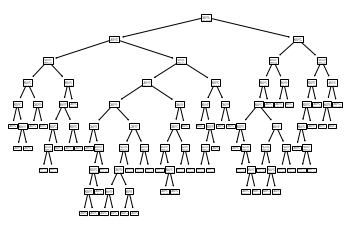

In [21]:
tree.plot_tree(H_decision_Bitree)
print("I can't see the value of each node. QQ")

Feature: [17  1  1  1  2  0  4  4  4  1  3  1  0 14 15  1  0  1  0  0  1  1  0  0
  1  0  0  1  0  0  0  0  1  0  0  1  0  0  0  0  1  0  1  0  0  1  1  0
  1  0  1  0  0  1  1  0  1  0]
Predict: Fail
Decision path: Feature[14]:15 <=8.5 go left, Feature[42]:1 >0.5 go right  =====>leaf,Predict:Fail


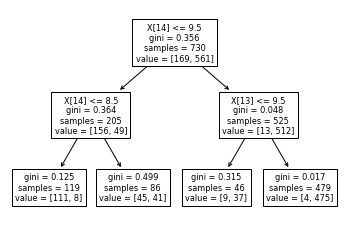

In [17]:
clf=tree.DecisionTreeClassifier(criterion='gini',max_depth=2).fit(H_B_F_train,H_B_L_train)
tree.plot_tree(clf)
i=32
print("Feature: "+str(H_B_F_test[i]))
pre=clf.predict(H_B_F_test)#0->fail
print("Predict: Fail")
print("Decision path: Feature[14]:"+str(H_B_F_test[i][14])+" <=8.5 go left, Feature[42]:"+str(H_B_F_test[i][42])+" >0.5 go right  =====>leaf,Predict:Fail")

## 7.Questions -Random Forest
Describe the difference between boosting and bagging<br>
<br>
boosting and bagging的目的都是為了同時產生多個分類器在資料中訓練，以增加精準度，但在資料的選取方式及目的會有所不同。<br>
<br>
bagging的概念是將資料隨機選取並訓練，同個動作訓練出多組的分類器，最後讓所有資料以投票的方式決定哪個分類器最佳，所以最終結果仍是"一個"分類器。<br>
其精神其實在於隨機抽樣，以抽樣的方式將雜訊的資料有機會不會訓練到，也就是所謂的降噪，讓雜訊不會影響訓練結果。<br>
<br>
boosting的概念是將上一次訓練出的結果，其中比較無法分類的那些資料集，拿到下一次再進行訓練。
<br>目的是為了將這些容易錯誤判讀的結果，藉由新的訓練，產生出專門為此分類的分類器。因此每個訓練都依賴上次的訓練結果。
<br>其精神在於因為如果將舊的資料拿去訓練，永遠無法分類出這些雜訊，所以應維持原先分類好的結果不動，而後保留這些雜訊並再產生一個分類器專門分類這些雜訊。

## 7.Questions -KNN
Pick 2 features, draw and describe the KNN decision boundaries<br>
先將資料拆到2個feature。再用先前的方法訓練。訓練完後將範圍一個一個點放入訓練結果後<br>
拿該區間每隔0.01用numpy的meshgrid分隔個點做預測，再依預測結果用matplotlib.pyplot中的pcolormesh塗上對應顏色。<br>
利用matplotlib.pyplot中的scatter把training data標示出來(圓點)。<br>
<br>
Show the prediction and reasoning of 1-samples in the validation set.<br>
假設有一個sample的點為[ 1.81115928 -1.45119388]，現在這個點找他周圍K(K=3)個最近鄰居，他會發現他最近的3個鄰居中，最多的是紅色(本題應為2紅色，1綠色)<br>
因此這個sample也被歸類為紅色，也就是預測結果為F

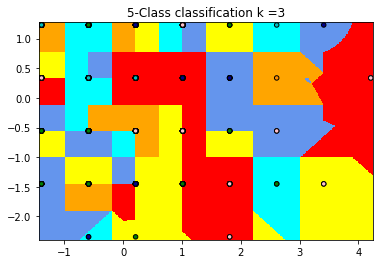

Feature: [ 1.81115928 -1.45119388]
Predict: F


In [23]:
cmap_light = ListedColormap(['orange', 'cyan', 'cornflowerblue','yellow','red'])
cmap_bold = ListedColormap(['darkorange', 'c', 'darkblue','green','pink'])

clf = neighbors.KNeighborsClassifier(n_neighbors=3, weights='distance')
clf.fit(H_F_nor_F_train[:, :2], H_Five_L_train)
x_min, x_max = H_F_nor_F_train[:, 0].min()-0.05, H_F_nor_F_train[:, 0].max()+0.05
y_min, y_max = H_F_nor_F_train[:, 1].min()-0.05 , H_F_nor_F_train[:, 1].max()+0.05
x_color,y_color=np.meshgrid(np.arange(x_min, x_max, 0.01),np.arange(y_min, y_max, 0.01))
perdict_color = clf.predict(np.c_[x_color.ravel(), y_color.ravel()])
perdict_color = perdict_color.reshape(x_color.shape)
plt.figure()
plt.pcolormesh(x_color, y_color, perdict_color, cmap=cmap_light)
plt.scatter(H_F_nor_F_train[:,0], H_F_nor_F_train[:,1], c=H_Five_L_train, cmap=cmap_bold, edgecolor='k', s=20)
plt.xlim(x_color.min(), x_color.max())
plt.ylim(y_color.min(), y_color.max())
plt.title("5-Class classification k =3")
plt.show()
print("Feature: "+str(H_F_nor_F_train[1,:2]))
pre=clf.predict(H_F_nor_F_train[:,:2])#F
print("Predict: F")